In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import pathlib as pl
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

In [2]:
fig_num = 'ED1'

panel = None
subpanel = None

def savefig(fig=None, title=None):
    fig = fig or plt.gcf()
    title = title or 'Fig_'+'_'.join([str(el) for el in [fig_num, panel, subpanel] if el is not None])
    print(f'Saving {title} in {graph_pth}:', end='')
    for ext in ['svg', 'png']:
        try:
            fig.savefig(graph_pth / f'{title}.{ext}', dpi=600, transparent=True)
            print(f' [.{ext}]', end='')
        except AttributeError:
            print(f' [.{ext} failed]', end='')
    print(' done')

# JG075F: L-MMMMx blocker tripartite competition matrix

In [3]:
cmax = 50

JG075F = (
    QuantStudio(data_pth / 'JG075F L-MMMMx blocker tripartite competition matrix.xlsx', 'JG075F')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore('FAM')
)

# Denote reaction conditions
JG075F.reactions.wide = (
    JG075F.reactions.wide
    .drop(columns=['Sample'])
    .merge(pd.read_csv(data_pth / 'JG075F Plate Map.csv'), on='Well')
#     .assign(lg10_Blocker = lambda df: np.log10(df['Blocker μM']))
#     .replace({'lg10_Blocker': {-np.inf: -2}})
#     .drop(columns=['CT','lg10_Copies','Target'])
)


JG075F.reactions.neaten()
JG075F.extract_endpoints(cmax=cmax)
endpoints = JG075F.endpoints
JG075F.reactions

,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Task,Comments,...,Reaction,WT_lg10_Copies,SNV_lg10_Copies,Blocker μM,WellName,Sample,Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,1,0.000313,0.002408
1,JG075F,1,HEX,-inf,False,A1,0.0,HEX,UNKNOWN,,...,1,1,-2,0.0,A1,JG075F_001,L-MMMMx,1,-0.001171,0.000397
2,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,2,0.001418,0.001183
3,JG075F,1,HEX,-inf,False,A1,0.0,HEX,UNKNOWN,,...,1,1,-2,0.0,A1,JG075F_001,L-MMMMx,2,-0.001190,0.000229
4,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,3,0.000909,0.001057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44755,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,58,0.917827,0.586347
44756,JG075F,384,FAM,-inf,False,P24,0.0,FAM,UNKNOWN,,...,744,8,7,10.0,P24,JG075F_384,L-MMMMx,59,0.018171,0.004682
44757,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,59,0.922703,0.589323
44758,JG075F,384,FAM,-inf,False,P24,0.0,FAM,UNKNOWN,,...,744,8,7,10.0,P24,JG075F_384,L-MMMMx,60,0.016668,0.006137


In [4]:
nonblank_endpoints = endpoints.query('SNV_lg10_Copies > 0')

ds = gmb.DataSet(nonblank_endpoints, outputs=['SignalDifference'])
gp = gmb.GP(ds).fit(continuous_dims = ['WT_lg10_Copies', 'SNV_lg10_Copies', 'Blocker μM'],
                   linear_dims = ['WT_lg10_Copies', 'SNV_lg10_Copies', 'Blocker μM']
                   )

Saving Fig_ED1_E_i in /home/john/projects/CAN_paper/fig_ed1/graphics: [.svg] [.png] done


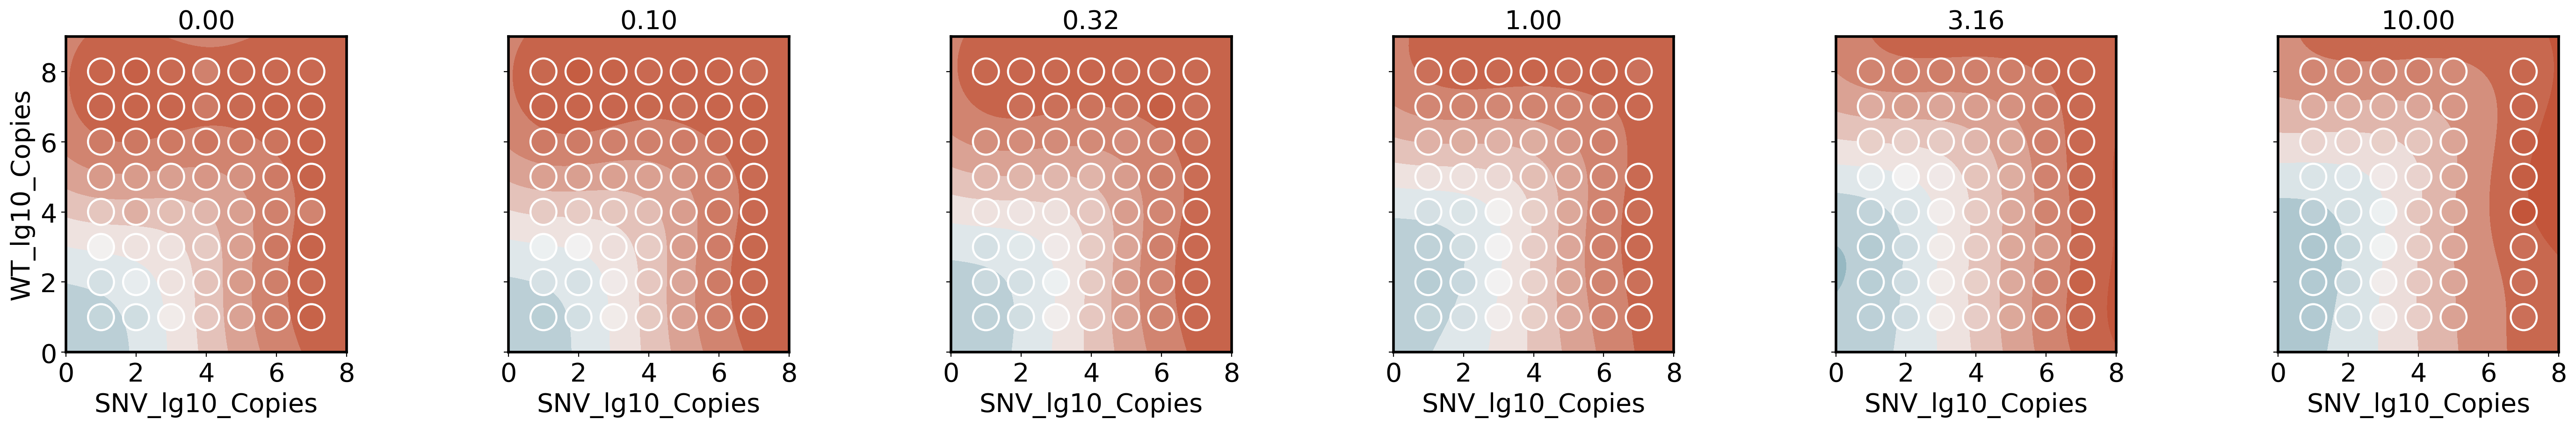

In [5]:
hue = 'SignalDifference'
extent = np.max(np.abs(nonblank_endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
palette = sns.diverging_palette(220, 20)#, as_cmap=True)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

g = sns.relplot(data=nonblank_endpoints, col="Blocker μM",
                x = 'SNV_lg10_Copies', y='WT_lg10_Copies',
                hue='SignalDifference', hue_norm=norm,
                palette=cmap, legend=False,
                kind='scatter', height=5, aspect=1.0, s=20**2, zorder=10,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for col_val, ax in g.axes_dict.items():
    
    ax.set_aspect('equal')
    ax.set(yticks=[0,2,4,6,8], xticks=[0,2,4,6,8], ylim=[0,9], xlim=[0,8]);
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(SNV_lg10_Copies=[0,8], WT_lg10_Copies=[0,9])
    XY = gp.prepare_grid(at=at, limits=limits)
    SNV = XY['SNV_lg10_Copies']
    WT = XY['WT_lg10_Copies']
    sig = gp.predict_grid(with_noise=False)
    
    plt.sca(ax)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    pc = gmb.ParrayPlotter(x=SNV, y=WT, z=sig)(plt.contourf, cmap=cmap, norm=norm, zorder=-10)
    
plt.tight_layout();

panel = 'E'
subpanel = 'i'
savefig()

In [6]:
pal = sns.color_palette("ch:s=-.2,r=.6", n_colors=9)

g = sns.FacetGrid(data=nonblank_endpoints, col="Blocker μM",
                  height=4, aspect=1,
                  **{'margin_titles': True, 'despine': False})

for col_val, ax in g.axes_dict.items():
    for copies, rgb in zip(np.arange(1,9)[::-1], pal[1:]):
        at = gp.parray(**{'Blocker μM': col_val, 'WT_lg10_Copies': copies})
        limits = gp.parray(SNV_lg10_Copies=[0, 8])
        X = gp.prepare_grid(at=at, limits=limits)['SNV_lg10_Copies']
        sig = gp.predict_grid(with_noise=False)
        
        plt.sca(ax)
        gmb.ParrayPlotter(x=X, y=sig).plot(palette=sns.light_palette(rgb))
        
#         if copies in [1,8]:
        sns.scatterplot(data = endpoints[(endpoints["Blocker μM"]==col_val) & (endpoints["WT_lg10_Copies"]==copies)],
                        x='SNV_lg10_Copies', y='SignalDifference', s=15**2, color=sns.light_palette(rgb)[-3],
                        ax=ax)
    ax.axvline(-1, color='k')

g.set(xticks=[-2,0,2,4,6,8], xticklabels=["-ve",0,2,4,6,8], ylim=[-0.5, 1.1], xlim=[-3, 9])
plt.tight_layout();

panel = 'E'
subpanel = 'ii'
savefig()

: 

: 

Saving..Done


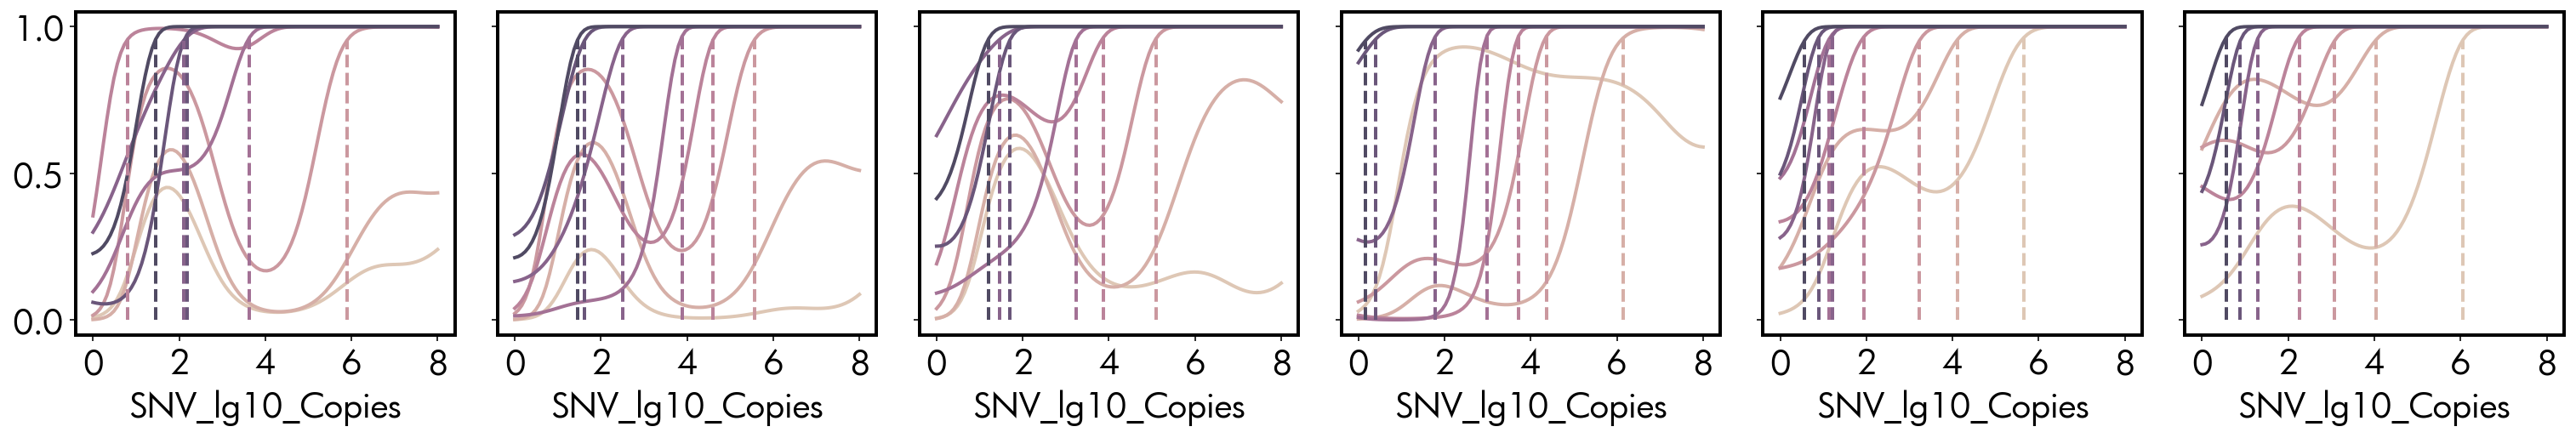

In [ ]:
pal = sns.color_palette("ch:s=-.2, r=.6", n_colors=9)

g = sns.FacetGrid(data=nonblank_endpoints, col="Blocker μM",
                  height=4, aspect=0.9,
                  **{'margin_titles': True, 'despine': False})

for col_val, ax in g.axes_dict.items():
    for copies, rgb in zip(np.arange(1,9)[::-1], pal[1:]):
        at = gp.parray(**{'Blocker μM': col_val, 'WT_lg10_Copies': copies})
        limits = gp.parray(SNV_lg10_Copies=[0, 8])
        X = gp.prepare_grid(at=at, limits=limits)['SNV_lg10_Copies']
        sig = gp.predict_grid(with_noise=True)
        
        zero = endpoints[
            (endpoints["Blocker μM"]==col_val) &
            (endpoints["WT_lg10_Copies"]==copies) &
            (endpoints["SNV_lg10_Copies"]==-2)
        ]['SignalDifference']
        
        if len(zero)>0:
            plt.sca(ax)
            gmb.ParrayPlotter(x=X, y=sig.dist.sf(zero)).plot(palette=sns.light_palette(rgb))

            LOD_idx = np.argmax(sig.dist.sf(zero)>0.95)
            if LOD_idx>0:
                LOD = X[LOD_idx]
                crossing_pt = sig.dist.sf(zero)[LOD_idx]
                color=sns.light_palette(rgb)[-2]
                plt.plot([LOD, LOD], [0, crossing_pt], color=color, ls='--')
        
g.set(xticks=[0,2,4,6,8])
plt.tight_layout();